In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_similarity_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 1
path_train = 'D:/dataset/tgs/train'
path_test = 'D:/dataset/tgs/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

In [3]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

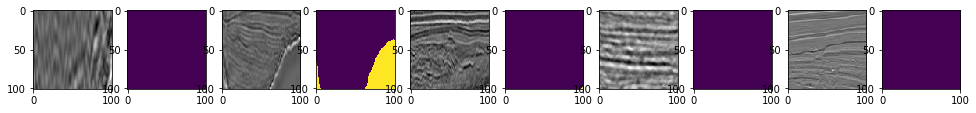

In [4]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name + '.png')
    img_mask = imread(train_path_masks + "/" + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]


In [6]:
#Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


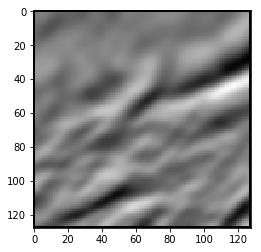

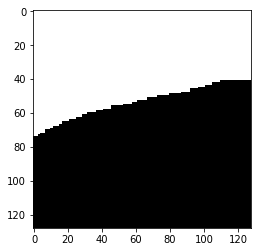

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [8]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [9]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [10]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

In [11]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [12]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]


In [13]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [14]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

In [15]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
train_losses = []
val_losses = []
train_losses = train_losses.type(np.float32)
val_losses = val_losses.astype(np.float32)

AttributeError: 'list' object has no attribute 'type'

In [22]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(2):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.item())
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))

Epoch: 1. Train Loss: 0.24985644907023. Val Loss: 0.26924899220466614
Epoch: 2. Train Loss: 0.23493411523842178. Val Loss: 0.2570314292724316


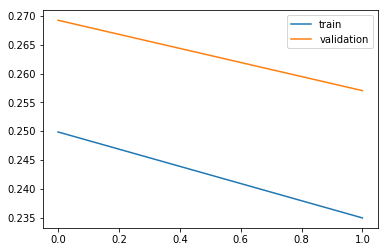

In [23]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

In [24]:
y_pred_true_pairs = []
for images, masks in val_loader:
    images = Variable(images.cuda())
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))


In [25]:
# https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
for threshold in np.linspace(0, 1, 11):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        prediction = (y_pred > threshold).astype(int)
        iou = jaccard_similarity_score(mask.flatten(), prediction.flatten())
        ious.append(iou)
        
    accuracies = [np.mean(ious > iou_threshold)
                 for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))


Threshold: 0.0, Metric: 0.149
Threshold: 0.1, Metric: 0.747
Threshold: 0.2, Metric: 0.846
Threshold: 0.3, Metric: 0.861
Threshold: 0.4, Metric: 0.859
Threshold: 0.5, Metric: 0.856
Threshold: 0.6, Metric: 0.846
Threshold: 0.7, Metric: 0.822
Threshold: 0.8, Metric: 0.785
Threshold: 0.9, Metric: 0.721
Threshold: 1.0, Metric: 0.581
